# Questions

### 1. What features did you consider?

    The challenge was to predict the virality of new articles. I interpreted that as meaning the only information available would be a row in the shared articles table with the 'eventType' as 'CONTENT SHARED.' Therefore, I only used the user interactions table as a means to calculate virality of the existing dataset.
    Given this assumption, the features I used were the author ID, website domain, title, and text. I don't have a lot of natural language processing experience, but I figured that would be the only way to improve the model and used it as an opportunity to dip my toes in to that field. I did some very basic NLP on the title and text fields for additional features.
    
### 2. What model did you use and why?

    My first choice was between a classifier and a regressor. After attempting a couple different regression models, I decided a classification may be more useful and easier to evaluate. Since the goal is to choose articles to showcase, I assumed that a classification model would be fitting for data volume reflective of the dataset given. I chose 6 models to compare using a 10-fold cross validation method: random forest, logistic regression, k nearest neighbors, decision tree, gaussian naive bayes, and support vector clustering. logistic regression had the highest predicted mean and highest predicted lower bound so I went with that one.

### 3. What was your evaluation metric for this?

    When comparing models, cross validated accuracy scores and standard deviations for those score distributions were used. Accuracy scores are determined by dividing the number of correct predictions by the number of samples. 
    When evaluating the final logistic regression model that I used, an accuracy score and confusion matrix are both presented. The confusion matrix shows the number of correct and incorrect predicitons for each partition of the dataset (in this case, True or False). 
    
### 4. What features would you like to add to the model in the future if you had more time?

    I would definitely do more natural language processing to get more derivative information from the title and text. Specifically, I might try classifying articles by subject, such as technology, politics, sports, etc. I might also try looking at the tone of the articles and titles, categorizing based on things like urgency, positivity/negativity, or subjectivity/obbjectivity, for example. I could also do a scoring system based on use of specific words to see if any words drove more engagement. Further classification might lead to insights about what kinds of articles become viral and any kind of categorization would be a good starting point.
    
### 5. What other things would you want to try before deploying this model in production.

    Overfitting is definitely going to be a problem with this model. The dataset is not huge and my skill with nlp is such that I would need a large dataset to make a well functioning model. I chose to go with a classification because of the limited dataset and because the goal of picking articles to be showcased can be adequately fulfilled using a classification.
    Given the need for a model that can be scaled to higher data volume, velocity, and variety, a regression model is better suited for production. After the development of additional features and collection of more data, I would try a regression model.
    I would also like to implement a mechanism so that the model could improve and adjust over time. Things that induce virality in the future will likely not be the same things that do that now. In that same vein, introducing a mechanism to avoid self-reinforcing behavior so that different kinds of articles can occasionally see the spotlight. After all, the ultimate goal is to drive engagement to the platform and not just serve people the same content all the time. 

# Modeling

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns

In [2]:
df_shared = pd.read_csv('shared_articles.csv')
df_users = pd.read_csv('users_interactions.csv')

Since the purpose is to predict the virality of new posts, only data in df_shared will be looked at for making predictions. df_users will be used to calculate virality for the purpose of supervised learning. It will also be used for feature generation.

In [3]:
df = df_shared[df_shared['eventType'] == 'CONTENT SHARED']

In [4]:
df_users['COUNT'] = 1
group_data = df_users.groupby(['contentId','eventType'])['COUNT'].sum().reset_index() 
print(group_data)

                contentId        eventType  COUNT
0    -9222795471790223670         BOOKMARK      1
1    -9222795471790223670  COMMENT CREATED      2
2    -9222795471790223670           FOLLOW      3
3    -9222795471790223670             LIKE      4
4    -9222795471790223670             VIEW     16
...                   ...              ...    ...
7335  9217155070834564627  COMMENT CREATED      2
7336  9217155070834564627             VIEW     14
7337  9220445660318725468             LIKE      2
7338  9220445660318725468             VIEW     50
7339  9222265156747237864             VIEW      5

[7340 rows x 3 columns]


In [5]:
df_viral = group_data.pivot_table('COUNT', ['contentId'], 'eventType')

In [6]:
df_viral = df_viral.fillna(0)

In [7]:
def virality(row):
   return (1* row['VIEW']) + (4*row['LIKE']) + (10*row['COMMENT CREATED']) +( 25*row['FOLLOW'] )+ (100*row['BOOKMARK'])

df_viral['virality'] = df_viral.apply(lambda row: virality(row), axis=1)

In [8]:
# removing rows where virality is not known
df = df[df.contentId.isin(df_viral.index)]

In [9]:
# adding virality column to df
df['virality'] = df_viral.loc[df['contentId'], 'virality']
for index in df.index:
    df.loc[index,'virality'] = df_viral.loc[df.loc[index,'contentId'],'virality']

In [10]:
df = df.drop('eventType', axis = 1)

calculating domain popularity vs virality

In [11]:
# website domain
import tldextract
def get_site(row):
    info = tldextract.extract(row['url'])
    return(info.domain)   

In [12]:
df['domain'] = df.apply(get_site, axis=1)

In [13]:
df[df['domain'] == 'nytimes'].virality.mean()

115.21428571428571

In [14]:
def domain_popularity(row):
    return(df[df['domain'] == row['domain']].virality.mean())

In [15]:
df['domain popularity'] = df.apply(domain_popularity, axis=1)

In [16]:
df['domain popularity'].corr(df['virality'])

0.7650940565859109

Author popularity vs virality

In [17]:
def author_popularity(row):
    return(df[df['authorPersonId'] == row['authorPersonId']].virality.mean())

In [18]:
df['author popularity'] = df.apply(author_popularity, axis=1)

In [19]:
df['author popularity'].corr(df['virality'])

0.4525381623505533

Article length vs virality

In [20]:
import textstat

In [21]:
def article_length(row):
    return(textstat.syllable_count(row['text']))

In [22]:
df['article length'] = df.apply(article_length,axis=1)

In [23]:
df['article length'].corr(df['virality'])

0.13801101293308465

Readability vs virality

In [24]:
import textstat

In [25]:
def readability_score(row):
    text = row['text']
    return(textstat.difficult_words(text))

In [26]:
df['readability score'] = df.apply(readability_score,axis=1)

In [27]:
df['readability score'].corr(df['virality'])

0.13739140999152524

Title length vs virality

In [28]:
# use textstat syllable count
def title_length(row):
    return(textstat.syllable_count(row['title']))

In [29]:
df['title length'] = df.apply(title_length, axis=1)

In [30]:
df['title length'].corr(df['virality'])

-0.05591979121137344

In [31]:
df.head()

,timestamp,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,virality,domain,domain popularity,author popularity,article length,readability score,title length
1,1459193988,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,1.0,nytimes,115.214286,15.117647,1621,195,18
2,1459194146,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,1.0,cointelegraph,8.062500,15.117647,495,82,17
3,1459194474,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,22.0,googleblog,82.096154,88.838462,386,37,7
5,1459194522,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,2.0,coindesk,45.708333,15.117647,454,67,15
7,1459194599,4119190424078847945,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/blockchai...,Blockchain Technology Could Put Bank Auditors ...,When most people think about computers and rob...,en,1.0,bitcoinmagazine,29.000000,15.117647,1105,135,14


## Models

### Classifiers

Goal is to classify viral vs not viral so must determine a virality score where an article can be considered viral

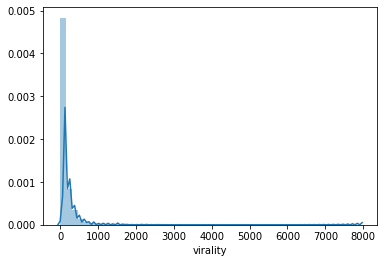

In [32]:
sns.distplot(df['virality'])

In [33]:
vir_std = df['virality'].std()

In [34]:
vir_mean = df['virality'].mean()

In [35]:
df_class = df

In [37]:
threshold = vir_mean + vir_std
def classify_virality(row):
    if row['virality'] > threshold:
        return True
    else:
        return False

In [38]:
df_class['virality'] = df_class.apply(classify_virality, axis=1)

In [39]:
#train test split
from sklearn.model_selection import train_test_split
X = df_class.loc[:,['domain popularity', 'author popularity', 'title length', 'article length', 'readability score']]
y = df_class['virality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

LR: 0.944613 (0.017451)
KNN: 0.941588 (0.019931)
DTC: 0.910037 (0.021634)
NB: 0.932521 (0.023199)
SVM: 0.938568 (0.021756)
RFC: 0.940918 (0.020647)


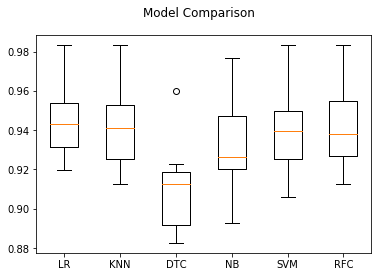

In [45]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))

# evaluate each model
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    out = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(out)
    
# model comparison boxplot
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Logistic Regression Model

In [41]:
LR = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_lr = LR.predict(X_test)
pred_proba_lr = LR.predict_proba(X_test)
LR.score(X_test,y_test)

0.9345637583892618

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, pred_lr))
print(confusion_matrix(y_test, pred_lr))

              precision    recall  f1-score   support

       False       0.94      0.99      0.97       548
        True       0.80      0.25      0.38        48

    accuracy                           0.93       596
   macro avg       0.87      0.62      0.67       596
weighted avg       0.93      0.93      0.92       596

[[545   3]
 [ 36  12]]
